### importing packages and functions:
All functions are contained in function.py

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic
import warnings
%matplotlib inline
import os
import time
import functions
import shapely

In [7]:
import functions

This notebook aims to calculate the distance between different raingauges. Note this was the first attempt at using geospatial data, later on geopandas was used rather than own code to export data. Data obatined from: <br>
<br>
Met Office (2021): MIDAS Open: UK daily rainfall data, v202107. NERC EDS Centre for Environmental Data Analysis, 08 September 2021. doi:10.5285/d6bcf4171c2f4754a7455d00deda0f72. http://dx.doi.org/10.5285/d6bcf4171c2f4754a7455d00deda0f72
<br>
<br>
Specifically the station meta data was used

## Importing Data

1850 there were only 2 stations:

In [8]:
data1850 = pd.read_csv("Data/midas_raindrnl_185301-185312.txt",sep=',')

In [9]:
data1850.ID.nunique()

2

Whilst 2021 there were 2348

In [10]:
data2021 = pd.read_csv("Data/midas_raindrnl_202101-202112.txt",sep=',')

C:\Users\david\AppData\Local\Temp\ipykernel_5924\1821358648.py:1: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data2021 = pd.read_csv("Data/midas_raindrnl_202101-202112.txt",sep=',')


In [11]:
data2021.OB_DAY_CNT.nunique()

2348

Note afterwards: of these 2348, only 348 had data in 2020, so these were only considered (see code at bottomn)

In [12]:
data_stations_hourly = pd.read_csv("Data/midas-open_uk-hourly-rain-obs_dv-202107_station-metadata.csv",
                                    sep=",",index_col=0,skipfooter=1)
data_stations_hourly.head(3)

C:\Users\david\AppData\Local\Temp\ipykernel_5924\595143646.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data_stations_hourly = pd.read_csv("Data/midas-open_uk-hourly-rain-obs_dv-202107_station-metadata.csv",


,station_name,station_file_name,historic_county,station_latitude,station_longitude,station_elevation,first_year,last_year
src_id,,,,,,,,
1,FOULA,foula,shetland,60.154,-2.074,22,1989,1995
3,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020
4,SUMBURGH,sumburgh,shetland,59.879,-1.299,7,1978,1996


## Filtering for subsection to reduce compute times
First look at a smaller subsection of data

In [8]:
data_cumbria = data_stations_hourly.query("historic_county == 'cumbria'")
data_cumbria.head(3)

,station_name,station_file_name,historic_county,station_latitude,station_longitude,station_elevation,first_year,last_year
src_id,,,,,,,,
1054,ESKMEALS,eskmeals,cumbria,54.325,-3.408,8,1994,2001
1055,ST BEES HEAD NO 2,st-bees-head-no-2,cumbria,54.518,-3.615,124,1992,2020
1060,KESWICK,keswick,cumbria,54.614,-3.157,81,1992,2020


### Plot showing the location of points
This gives a quick representation, however is better done in GIS

In [ ]:
data_cumbria.plot("station_longitude","station_latitude","scatter");

### Package used to caculate distance between two points
Geopy is used to caculate the geodesic distance between the differen points, here an example is given

In [ ]:
# from geopy.distance import geodesic
p1 = 54.325,-3.408
p2 = 54.518,-3.615
print(geodesic(p1,p2).km)

This can be summarised into the distance_too_close function which takes a dataframe and a threshold and returns any stations closer than the threshold. <br>
Here all the hourly stations are used as input any any closer than 5km are returned.<br>
_Warning the cell bellow can take a minute or two_

In [ ]:
closeby_stations = functions.distance_too_close(data_stations_hourly, 5)
closeby_stations

To import this data into QGIS and process it into a map, it can be saved:

In [ ]:
functions.tuple_to_csv(closeby_stations,"Stations with closest closer than 5km")

## Plot:
or, the data returned can then be here:

In [ ]:
lst_x = []
lst_y = []
for i in closeby_stations:
    lst_x.append(i[0][0])
    lst_y.append(i[0][1])
plt.plot(lst_x,lst_y,"o");

### Now lets consider the closest other station per station

The same can be done as before computing the distance to all other points, however we consider the upperbound stations.<br>
The closest station is found, if it is further than the threshold it is returned

In [ ]:
far_stations = functions.distance_closest(data_stations_hourly, 40)
far_stations

In [ ]:
functions.tuple_to_csv(far_stations,"Stations with closestfurther than 40 km")

# Repeating for 2020 data

After some further investigation i found that when considering the "last_year", some gauges had been replaced or in use and therefore are no longer useful to consider. 

In [ ]:
data_stations_daily = pd.read_csv("Data/midas-open_uk-daily-rain-obs_dv-202107_station-metadata.csv",
                                  sep=",",index_col=0,skipfooter=1)
data_stations_daily.head(3)

In [ ]:
all_stations = data_stations_daily.append(data_stations_hourly)
current_stations = all_stations.query("last_year == 2020")
current_stations.head(3)

In [ ]:
current_far_stations = functions.distance_closest(current_stations, 40)
current_far_stations

In [ ]:
functions.tuple_to_csv(current_far_stations,"Current stations with closest being further than 40km")

In [ ]:
current_closeby_stations = functions.distance_too_close(current_stations, 5)
current_closeby_stations

In [ ]:
functions.tuple_to_csv(current_closeby_stations,"Current stations with closest less than 5km")

In [ ]:
current_closeby_stations

In [ ]:
current_far_stations

# using the buffer to look at overlap in gauges 

Importing from other directory:

In [13]:
# getting dirctory
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# moving one up
path_daily = os.path.join(parentDirectory, 'Slope steepness from DEM', 'Gauge Data', "Daily-Gauges-UK.shp")
path_hourly = os.path.join(parentDirectory, 'Slope steepness from DEM', 'Gauge Data', "Hourly-Gauges-UK.shp")
path_outline = os.path.join(parentDirectory, 'Drainage Basins', 'Drainage Basins Data',"Outline UK","gadm36_GBR_0.shp")

#loading
daily_gauges = gpd.read_file(path_daily,crs=4326)
hourly_gauges = gpd.read_file(path_hourly,crs=4326)
Uk_outline = gpd.read_file(path_outline,crs=4326)

#combining and displaying
gauges = hourly_gauges.append(daily_gauges)
gauges.reset_index(drop=True,inplace=True)

C:\Users\david\AppData\Local\Temp\ipykernel_5924\337606456.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gauges = hourly_gauges.append(daily_gauges)


Loop over a range of values for a buffer, we run from 0 to 0.5. The uk has a spacing of a couple degrees

In [10]:
len(gauges)

368

In [11]:
lst = []
buffer = []
for i in np.linspace(0.0005,0.5,num=50):
    instance = gauges.copy()
    warnings.filterwarnings("ignore")
    instance.geometry = instance.geometry.buffer(i)
    lst.append(instance)
    buffer.append(i)


#### Plot the 3 diffeerent values showing the plots growing in size

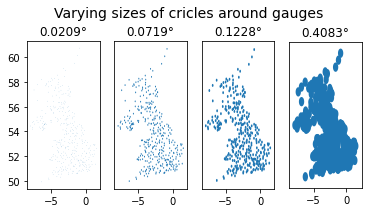

In [30]:
fig, ax = plt.subplots(1,4, tight_layout=False)
title = "Varying sizes of cricles around gauges"
fig.suptitle(title,y=0.88,fontsize=14)
for i, n  in enumerate([2,7,12,40]):
    lst[n].plot(ax=ax[i])
    ax[i].set_title(f'{buffer[n]:.4f}°')
    if i > 0:
        ax[i].get_yaxis().set_visible(False)

ax[0].figure.savefig(f"Figures/{title}.png")

Consider this onde case:

In [72]:
n = 30
i = 105

We see that the a nearby cell overlaps

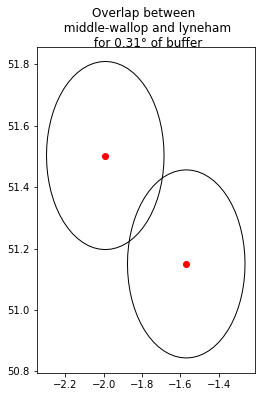

In [74]:
fig, ax = plt.subplots(1,figsize=(5,6))
overlap = lst[n].query(f'index == {i} or  index == {i+6}')
overlap_gpd = gpd.GeoDataFrame(overlap, crs=4326, geometry=overlap.geometry)
overlap_gpd.geometry.centroid.plot(ax=ax,color="red")
overlap_gpd.plot(color='none', edgecolor='black',ax=ax)

title = f"Overlap between \n " + \
        f" {lst[n].iloc[i].station_fi} and {lst[n].iloc[i+6].station_fi}" + \
        f" \n for {buffer[n]:.2f}° of buffer"
ax.set_title(title, y=0.98);
ax.figure.savefig(f"Figures/{title[:15]}two stations.jpg")

#### exporting to be loaded in over the DEM plot 

In [75]:
overlap_plot = lst[n].query(f'index == {i} or  index == {i+6}')
overlap_plot.to_file('overlap_station_plot')
overlap_plot

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry
105,00847,MIDDLE WALLOP,middle-wallop,hampshire,51.150,-1.570,90,1989,2020,"POLYGON ((-1.26368 51.15000, -1.26516 51.11998..."
111,00886,LYNEHAM,lyneham,wiltshire,51.503,-1.992,145,1957,2020,"POLYGON ((-1.68568 51.50300, -1.68716 51.47298..."


This can be done automatically with the following:

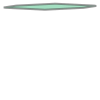

In [76]:
lst[n].query(f'index == {i}').overlay(lst[n].query(f'index != {i}'), how='intersection').geometry.iloc[0]

Compute the overlap for all the stations to every other station, for 50 different buffer sizes.<br>
(not very efficient but it works) <br>
Last runtime 19.2 min

In [77]:
run = False
if run:    
    start = time.time()
    nmax = len(lst) # total amount of variations of buffering
    imax = len(lst[0]) # amount of stations
    out = np.zeros((nmax,imax))
    for n in range(nmax):
        print(f'n={n}',end="\n")
        for i in range(imax):
            print(i,end="\r")
            out[n,i] = sum(lst[n].query(f'index == {i}').overlay(lst[n].query(f'index != {i}'), how='intersection').geometry.area)
    end = time.time()
    print((end-start)/60)

#### To save the hastle of 20min runtime, they have been saved

In [17]:
if run:    
    np.savetxt("Output/intersection-array.csv",out,delimiter=",")
    np.savetxt("Output/buffer-array.csv",buffer,delimiter=",")

And can then be loaded in

In [15]:
read_out = np.genfromtxt("Output/intersection-array.csv", delimiter=',')
read_buffer = np.genfromtxt("Output/buffer-array.csv", delimiter=',')

By summing over the horizontal axis of the output array, we get a total overlap per buffer size (running from 0 - 0.5 degrees)

In [19]:
print(len(buffer),len(np.sum(read_out, axis=1)))

50 50


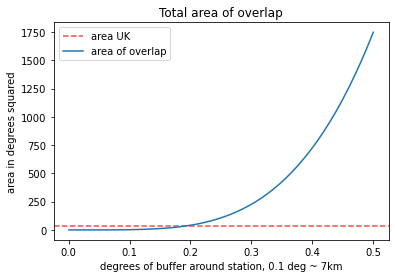

In [20]:
plt.axhline(Uk_outline.geometry.iloc[0].area, ls="--",color="r",alpha=0.7,label="area UK")
plt.plot(read_buffer, np.sum(read_out, axis=1),label="area of overlap")
plt.xlabel("degrees of buffer around station, 0.1 deg ~ 7km")
plt.ylabel("area in degrees squared")
plt.legend()
title = "Total area of overlap"
plt.title(title)
plt.savefig(f"Figures/{title}.jpg")

#### Would be interesting to compare to regular spaced grid:
[Code in cell bellow borrowed and adjusted from here](https://stackoverflow.com/questions/66010964/fastest-way-to-produce-a-grid-of-points-that-fall-within-a-polygon-or-shape)


In [33]:
# construct a rectangular mesh
resolution = 0.3
valid_points = []
polygon = Uk_outline.geometry.iloc[0]

latmin, lonmin, latmax, lonmax = polygon.bounds

# create prepared polygon
prep_polygon = shapely.prepared.prep(polygon)

# construct a rectangular mesh
points = []
for lat in np.arange(latmin, latmax, resolution):
    for lon in np.arange(lonmin, lonmax, resolution):
        points.append(shapely.geometry.Point((round(lat,4), round(lon,4))))

# validate if each point falls inside shape using
# the prepared polygon
valid_points.extend(filter(prep_polygon.contains, points))

In [36]:
len(gauges)

368

In [42]:
print(len(valid_points))
print(len(valid_points[:368]))
valid_points = valid_points[:368]

375
368


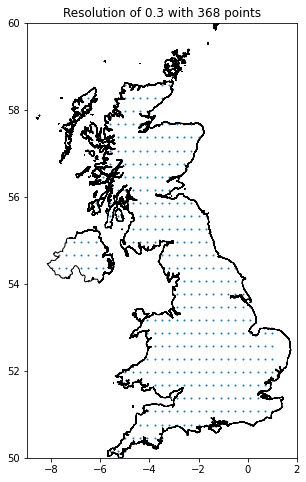

In [43]:
equal_spaced_points = gpd.GeoDataFrame(geometry=valid_points)

fig, ax = plt.subplots(1, figsize=(5,8))
equal_spaced_points.plot(ax=ax, markersize=1)
Uk_outline.plot(ax=ax,color="none")
ax.set_xlim((-9,2))
ax.set_ylim((50,60))
title = f"Resolution of {resolution} with {len(equal_spaced_points)} points"
ax.set_title(title);
ax.figure.savefig(f"Figures/{title}.png")

Repeat code above, again long run times so loaded for you<br>
last runtime 17.5 min, it automatically saves the files, you only need to load them bellow

In [45]:
run = False
if run:
    functions.run_buffer_spacing(equal_spaced_points, "equal-space")

n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25
n=26
n=27
n=28
n=29
n=30
n=31
n=32
n=33
n=34
n=35
n=36
n=37
n=38
n=39
n=40
n=41
n=42
n=43
n=44
n=45
n=46
n=47
n=48
n=49
17.019314177831014


In [47]:
read_out_spaced = np.genfromtxt("Output/intersection-array-equal-space.csv", delimiter=',')
read_buffer_spaced = np.genfromtxt("Output/buffer-array-equal-space.csv", delimiter=',')

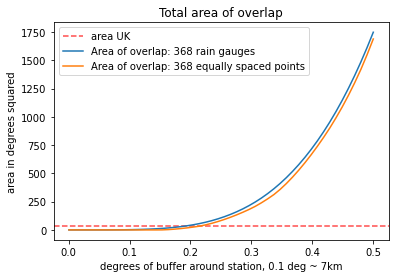

In [56]:
plt.axhline(Uk_outline.geometry.iloc[0].area, ls="--",color="r",alpha=0.7,label="area UK")

plt.plot(read_buffer, np.sum(read_out, axis=1),label=f"Area of overlap: {len(read_out[0])} rain gauges")
plt.plot(read_buffer_spaced, np.sum(read_out_spaced, axis=1),
         label=f"Area of overlap: {len(read_out_spaced[0])} equally spaced points")

plt.xlabel("degrees of buffer around station, 0.1 deg ~ 7km")
plt.ylabel("area in degrees squared")

plt.legend()
title = "Total area of overlap"
plt.title(title)
# plt.xlim(0.15+d,0.3+d)
plt.savefig(f"Figures/{title}-with-equalspaced.png")

Plotting can also be done per station

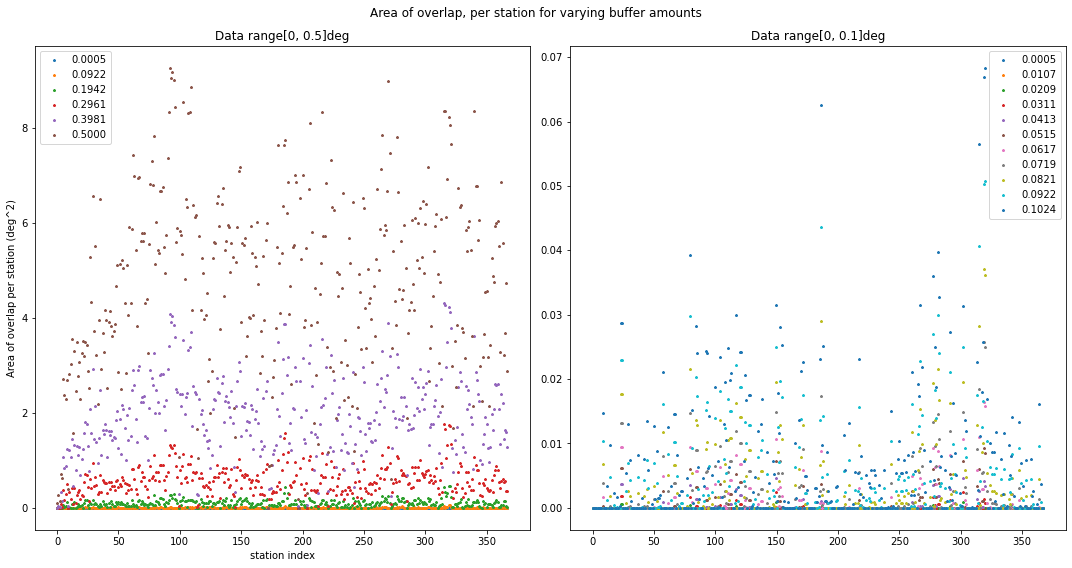

In [29]:
fig, ax =plt.subplots(1,2,tight_layout=True,figsize=(15,8))
title = "Area of overlap, per station for varying buffer amounts"
fig.suptitle(title)

for i in [0,9,19,29,39,49]:
    ax[0].plot(read_out[i],'*',markersize=2.5,label=f"{buffer[i]:.4f}")
    
ax[0].figure.savefig("Combined_plot.jpg")
ax[0].set_xlabel("station index")
ax[0].set_ylabel("Area of overlap per station (deg^2)");
ax[0].set_title("Data range[0, 0.5]deg")
ax[0].legend()

for i in [0,1,2,3,4,5,6,7,8,9,10]:
    ax[1].plot(read_out[i],'*',markersize=2.5,label=f"{buffer[i]:.4f}")
ax[1].legend()
ax[1].set_title("Data range[0, 0.1]deg")

ax[0].figure.savefig(f'Figures/{title}.png')